In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

In [2]:
INPUT_DATA = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

TRAINING_SIZE = 1000
TESTING_SIZE = 300

In [3]:
def feature_extraction(x, y, z):
    features = [np.mean(x), np.mean(y), np.mean(z), np.std(x), np.std(y), np.std(z)]
    #Median Absolute Deviation
    features.extend((np.mean(abs(x - features[0])), np.mean(abs(y - features[1])), np.mean(abs(z - features[2]))))
    #Jerk Signals
    features.extend((np.mean(np.diff(x)), np.mean(np.diff(y)), np.mean(np.diff(z)), np.std(np.diff(x)), np.std(np.diff(y)), np.std(np.diff(z))))
    features.extend((np.mean(abs(np.diff(x) - features[9])), np.mean(abs(np.diff(y) - features[10])), np.mean(abs(np.diff(y) - features[11]))))
    features.extend((max(x), max(y), max(z), min(x), min(y), min(z)))
    return features

def feature_selection(X):
    data = []
    for i in range(X.shape[0]):
        features = []
        for j in range(0, X.shape[2], 3):
            x = [X[i][u][j] for u in range(X.shape[1])]
            y = [X[i][u][j+1] for u in range(X.shape[1])]
            z = [X[i][u][j+2] for u in range(X.shape[1])]
            features.append(feature_extraction(x, y, z))
        data.append(features)
    return data

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in 
             [row.replace('  ', ' ').strip().split(' ') for row in file]
            ]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))


def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_ - 1

In [4]:
X_train_input_paths = ["data/train/" + signal + "train.txt" for signal in INPUT_DATA]
X_test_input_paths = ["data/test/" + signal + "test.txt" for signal in INPUT_DATA]
X_train = load_X(X_train_input_paths)
X_test = load_X(X_test_input_paths)

y_train_path = "data/y_train.txt"
y_test_path = "data/y_test.txt"
Y_train = load_y(y_train_path).ravel()
Y_test = load_y(y_test_path).ravel()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

print(X_train[0])
print(Y_train[0])

X = X_train[0:TRAINING_SIZE]
Y = Y_train[0:TRAINING_SIZE]
Xt = X_test[0:TESTING_SIZE]
Yt = Y_test[0:TESTING_SIZE]

print(X.shape)
print(Y.shape)
print(Xt.shape)
print(Yt.shape)

X = np.array(feature_selection(X))
Xt = np.array(feature_selection(Xt))

print(X.shape)
print(Xt.shape)

print(X[0])
#print(Xt[0])

np.savetxt("data/test_data_format.csv", X[0], fmt='%5s', delimiter=",")

(7352, 128, 9)
(7352,)
(2947, 128, 9)
(2947,)
[[  1.80851493e-04   1.07668098e-02   5.55606782e-02 ...,   1.01281703e+00
   -1.23216704e-01   1.02934100e-01]
 [  1.01385601e-02   6.57948013e-03   5.51248305e-02 ...,   1.02283299e+00
   -1.26875594e-01   1.05687201e-01]
 [  9.27557424e-03   8.92887823e-03   4.84047309e-02 ...,   1.02202797e+00
   -1.24003701e-01   1.02102503e-01]
 ..., 
 [ -1.14748406e-03   1.71443899e-04   2.64786393e-03 ...,   1.01844501e+00
   -1.24069601e-01   1.00385197e-01]
 [ -2.22265502e-04   1.57418102e-03   2.38105701e-03 ...,   1.01937199e+00
   -1.22745097e-01   9.98735502e-02]
 [  1.57550001e-03   3.07018892e-03  -2.26975698e-03 ...,   1.02117097e+00
   -1.21325999e-01   9.49874073e-02]]
4
(1000, 128, 9)
(1000,)
(300, 128, 9)
(300,)
(1000, 3, 24)
(300, 3, 24)
[[  2.26869062e-03  -1.65537116e-03  -8.12555104e-03   2.94102891e-03
    4.60070046e-03   1.85043626e-02   2.51075346e-03   3.61979101e-03
    1.32809971e-02   1.09814628e-05  -6.06032881e-05  -4.5535

In [5]:
# Input Data 

training_data_count = X.shape[0]  # 7352 training series (with 50% overlap between each serie)
test_data_count = Xt.shape[0]  # 2947 testing series
n_input = X.shape[2]  # 9 input parameters per timestep
n_steps = X.shape[1]  # 128 timesteps per series


# LSTM Neural Network's internal structure

n_hidden = 12 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X.shape, Y.shape, np.mean(X), np.std(X))
print(Xt.shape, Yt.shape, np.mean(Xt), np.std(Xt))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


Some useful info to get an insight on dataset's shape and normalisation:
(X shape, y shape, every X's mean, every X's standard deviation)
(1000, 3, 24) (1000,) 0.0876393 0.361263
(300, 3, 24) (300,) 0.0792338 0.355698
The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.


In [6]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # Linear activation
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many to one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS



In [7]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))



In [8]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X, step, batch_size)
    batch_ys = one_hot(extract_batch_size(Y, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: Xt,
                y: one_hot(Yt)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: Xt,
        y: one_hot(Yt)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))



Training iter #1500:   Batch Loss = 2.605763, Accuracy = 0.1446666717529297
PERFORMANCE ON TEST SET: Batch Loss = 2.5359630584716797, Accuracy = 0.15666666626930237
Training iter #30000:   Batch Loss = 2.151985, Accuracy = 0.14533333480358124
PERFORMANCE ON TEST SET: Batch Loss = 2.133793830871582, Accuracy = 0.05000000074505806
Training iter #60000:   Batch Loss = 1.708493, Accuracy = 0.3580000102519989
PERFORMANCE ON TEST SET: Batch Loss = 1.6620055437088013, Accuracy = 0.5099999904632568
Training iter #90000:   Batch Loss = 1.369121, Accuracy = 0.527999997138977
PERFORMANCE ON TEST SET: Batch Loss = 1.3453561067581177, Accuracy = 0.5366666913032532
Training iter #120000:   Batch Loss = 1.167191, Accuracy = 0.562666654586792
PERFORMANCE ON TEST SET: Batch Loss = 1.1729813814163208, Accuracy = 0.5866666436195374
Training iter #150000:   Batch Loss = 1.025560, Accuracy = 0.7026666402816772
PERFORMANCE ON TEST SET: Batch Loss = 1.1068642139434814, Accuracy = 0.5066666603088379
Training 

/Users/arshanrahman/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


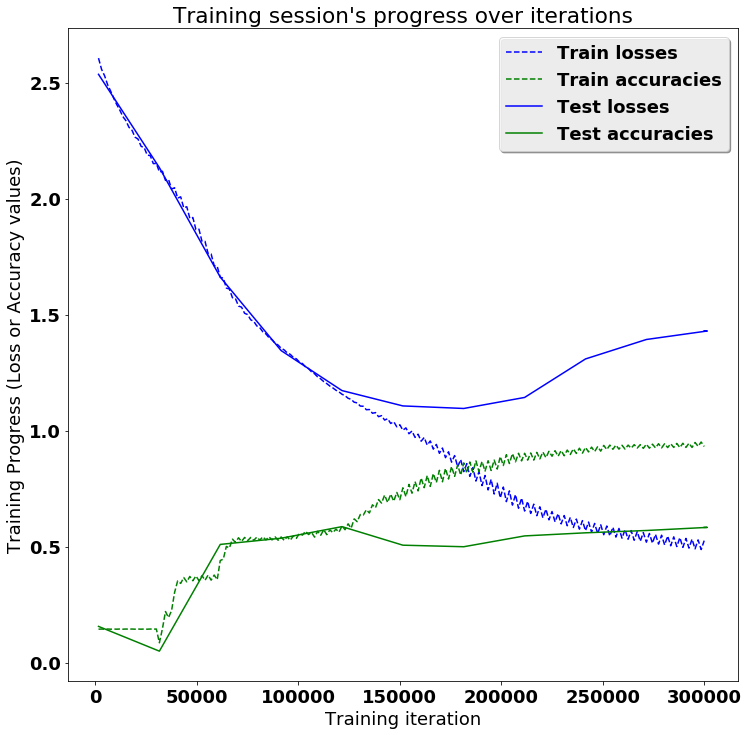

In [9]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

Testing Accuracy: 58.33333134651184%

Precision: 49.83605723370429%
Recall: 58.333333333333336%
f1_score: 51.85462167953862%

Confusion Matrix:
[[ 9 50  0  0  0  0]
 [17 21  8  0  0  0]
 [ 1  3 43  0  0  0]
 [ 0  0  0  0 46  0]
 [ 0  0  0  0 54  0]
 [ 0  0  0  0  0 48]]

Confusion matrix (normalised to % of total test data):
[[  3.          16.66666794   0.           0.           0.           0.        ]
 [  5.66666698   7.           2.66666675   0.           0.           0.        ]
 [  0.33333334   1.          14.33333302   0.           0.           0.        ]
 [  0.           0.           0.           0.          15.33333397   0.        ]
 [  0.           0.           0.           0.          18.           0.        ]
 [  0.           0.           0.           0.           0.          16.        ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


/Users/arshanrahman/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/arshanrahman/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/arshanrahman/anaconda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


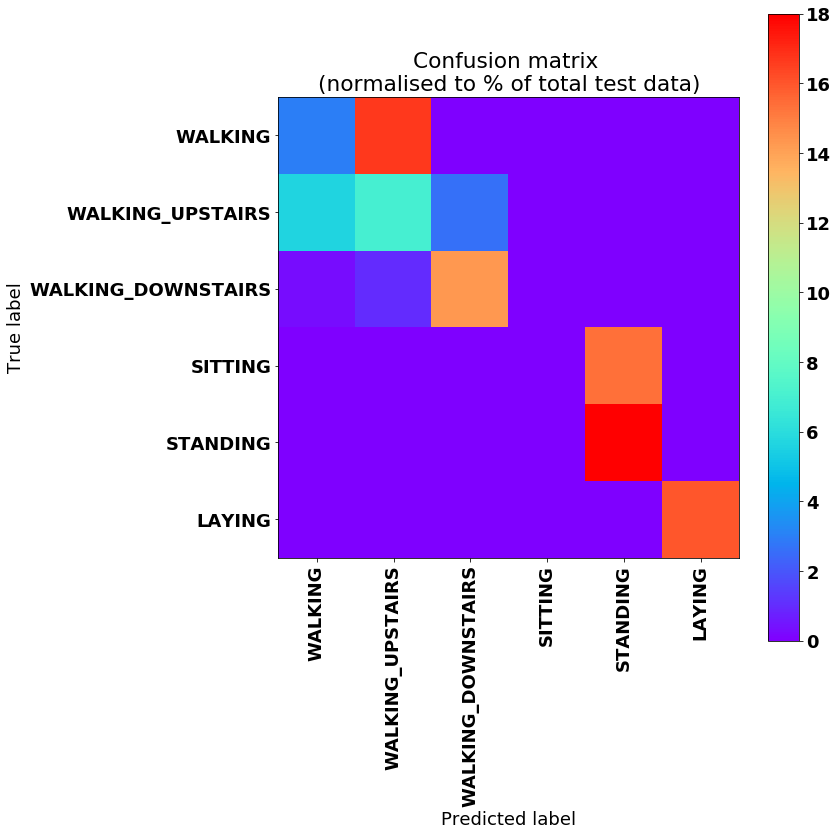

In [10]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(Yt, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Yt, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Yt, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Yt, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [11]:
sess.close()